In [57]:
# Initialize Otter
import otter
grader = otter.Notebook("lab09.ipynb")

# Lab 09: Model Selection, Regularization, and Cross-Validation
## Due Sunday, July 21, 11:59 PM PT

In this lab, you will practice using `scikit-learn` to generate models of various complexity levels. You'll then use validation sets and K-fold cross-validation to select the models that generalize the best.

To receive credit for a lab, answer all questions correctly and submit before the deadline.

**The on-time deadline is Sunday, July 21, 11:59 PM PT**. Please read the syllabus for the grace period policy. No late submissions beyond the grace period will be accepted. While course staff is happy to help you if you encounter difficulties with submission, we may not be able to respond to late-night requests for assistance (TAs need to sleep, after all!). **We strongly encourage you to plan to submit your work to Gradescope several hours before the stated deadline.** This way, you will have ample time to contact staff for submission support.

**This lab contains four written questions**, which will be graded based on completion and coherence. After submitting this assignment to the Lab 09 Coding assignment on Gradescope, Gradescope will automatically submit the PDF from this file to the Lab 09 Written assignment.

### Collaboration Policy
Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Lab Walk-Through
In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

**Note:** Some part of the video is recorded in Spring 2022. There may be slight inconsistencies between the version you are viewing and the version used in the recording, but content is identical.

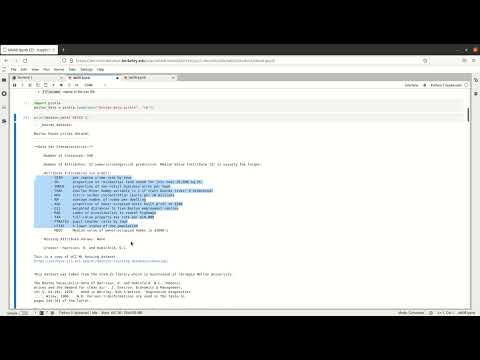

In [58]:
from IPython.display import YouTubeVideo
YouTubeVideo("uQ3E4pejmD8", list = 'PLQCcNQgUcDfqlXYhOXB-ZiE9V-4v-DU6I', listType = 'playlist')

In [59]:
# Run this cell to set up your notebook; no further action is needed.
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
sns.set()
sns.set_context("talk")

from IPython.display import display, Latex, Markdown

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

### Introduction

For this lab, we will use a toy dataset to predict the house prices in Boston with data provided by the `sklearn.datasets` package. There are more interesting datasets in the package if you want to explore them during your free time!

Run the following cell to load the data. `pickle.load()` will return a dictionary object which includes keys for:
- `data` : The independent variables/features (X),
- `target` : The response vector (Y),
- `feature_names`: The column names,
- `DESCR` : A full description of the data, and
- `filename`: The name of the CSV file.


In [60]:
import pickle
boston_data = pickle.load(open("boston_data.pickle", "rb")) 

print("Dictionary keys:")
print(boston_data.keys())

print()

print("Sum of the attributes:")
print(sum(boston_data.data))

Dictionary keys:
dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename', 'data_module'])

Sum of the attributes:
[1.82844292e+03 5.75000000e+03 5.63521000e+03 3.50000000e+01
 2.80675700e+02 3.18002500e+03 3.46989000e+04 1.92029160e+03
 4.83200000e+03 2.06568000e+05 9.33850000e+03 6.40245000e+03]


In [61]:
print(boston_data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 12 numeric/categorical predictive. Median Value (attribute 13) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

A look at the `DESCR` attribute tells us the data contains these features:

    1. CRIM      per capita crime rate by town
    2. ZN        proportion of residential land zoned for lots over 
                 25,000 sq.ft.
    3. INDUS     proportion of non-retail business acres per town
    4. CHAS      Charles River dummy variable (= 1 if tract bounds 
                 river; 0 otherwise)
    5. NOX       nitric oxides concentration (parts per 10 million)
    6. RM        average number of rooms per dwelling
    7. AGE       proportion of owner-occupied units built prior to 1940
    8. DIS       weighted distances to five Boston employment centres
    9. RAD       index of accessibility to radial highways
    10. TAX      full-value property-tax rate per 10,000 USD
    11. PTRATIO  pupil-teacher ratio by town
    12. LSTAT    % lower status of the population
    
Let's now convert this data into a `pandas` `DataFrame`. 

In [62]:
boston = pd.DataFrame(boston_data['data'], columns=boston_data['feature_names'])
boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33


<br>

---

### Question 1

Let's model this housing price data! Before we can do this, however, we need to split the data into training and validation sets. Remember that the response vector (housing prices) lives in the `target` attribute. A random seed is set here so we can deterministically generate the same splitting in the future if we want to test our result again and find potential bugs.

Use the sklearn's `train_test_split` [(documentation)](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to split out 10% of the data for the validation set. Call the resulting splits `X_train`, `X_validation`, `Y_train`, and `Y_validation`.

In [63]:
from sklearn.model_selection import train_test_split
np.random.seed(45) # DO NOT CHANGE

X = boston
Y = pd.Series(boston_data['target'])

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=0.1)

In [64]:
grader.check("q1")

q1 results: All test cases passed!

<br>

---

### Question 2a

As a warmup, fit a linear model to describe the relationship between the housing price and all available independent variables/features. We have imported `sklearn.linear_model` as `lm`, so you can use that instead of typing out the whole module name. Fill in the cell below to fit a model using the data contained in the training set. Then, use this fitted model to predict the housing prices for the validation set. We've written out the code to create a scatter plot showing the relationship between the predicted and actual housing prices in the validation set for you. 

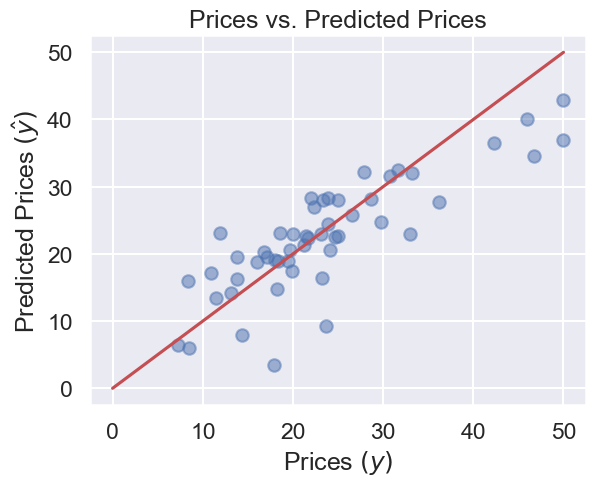

In [65]:
import sklearn.linear_model as lm

linear_model = lm.LinearRegression()

# Fit your linear model
# linear_model.fit(...)
linear_model.fit(X_train, Y_train)

# Predict housing prices on the validation set
Y_pred = linear_model.predict(X_validation)

# DO NOT CHANGE THE CODE BELOW THIS LINE
# Plot true prices vs. predicted values
plt.scatter(Y_validation, Y_pred, alpha=0.5)

# Plot the x=y diagonal line
plt.plot([0, 50], [0, 50], color='r')
plt.xlabel("Prices $(y)$")
plt.ylabel(r"Predicted Prices $(\hat{y})$")
plt.title("Prices vs. Predicted Prices");

In [66]:
grader.check("q2a")

q2a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 2b

Briefly analyze the scatter plot above. Do you notice any outliers? Write your answer in the cell below.

There are some outliers.

<!-- END QUESTION -->

Alternatively, we can plot the residuals against our model predictions (fitted values). This is known as the **residual plot**. Ideally, they would all be zero. Given the inevitability of noise, we would at least like them to be scattered randomly across the line where the residual is zero. By contrast, there appears to be a possible pattern with our model consistently underestimating prices for both very low and very high values, and possibly consistently overestimating prices towards the middle range below. We can figure out whether the model is overestimating or underestimating based on the sign of the residual: if it is negative, it means $y_i < \hat{y}_i$ so we are overestimating prices. Conversely, if the residual is positive, $y_i > \hat{y_i}$ and we end up underestimating prices.

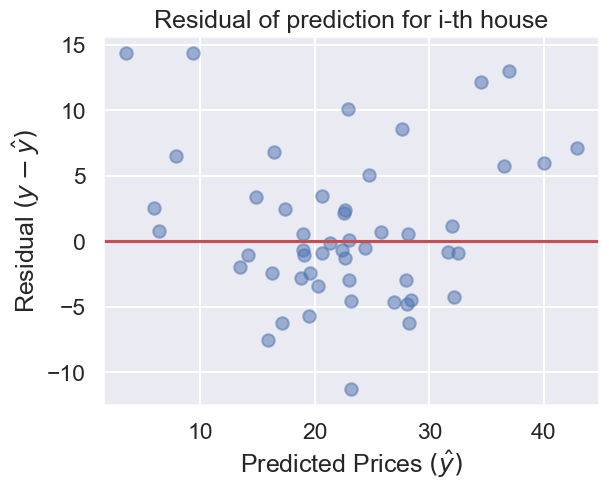

In [67]:
plt.scatter(Y_pred, Y_validation - Y_pred, alpha=0.5)
plt.ylabel(r"Residual $(y - \hat{y})$")
plt.xlabel(r"Predicted Prices $(\hat{y})$")
plt.title("Residuals vs. Predicted Prices")
plt.title("Residual of prediction for i-th house")
plt.axhline(y = 0, color='r');

<br>

---

### Question 3a

As we see in the scatter plots above, our model is not perfect. If it were perfect, the first scatter plot of predicted vs. true prices would follow the identity line (i.e., a line of slope 1 or $\hat{y} = y$). In contrast, the second scatter plot of residuals vs. predicted prices would be scattered randomly around the line where the residual is 0. To quantify the performance of the model, we will compute the Root Mean Squared Error (RMSE) of the predicted responses: 

$$
\textbf{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^n \left( y_i - \hat{y}_i \right)^2 }
$$

Fill in the function below to compute the RMSE. Then, assign `train_error` to the model’s RMSE when making predictions on the training data and `validation_error` to the model’s RMSE when making predictions on the validation set. Your implementation **should not** use `for` loops.

In [68]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: An array of the predictions from the model.
        actual_y: An array of the ground truth labels.
        
    Returns:
        The root mean square error between the predictions and ground truth labels.
    """
    n = len(actual_y)
    return np.sqrt(np.sum((actual_y - predicted_y)**2) / n)

train_error = rmse(Y_train, linear_model.predict(X_train))
validation_error = rmse(Y_validation, Y_pred)

print("Training RMSE:", train_error)
print("Validation RMSE:", validation_error)

Training RMSE: 4.633297105625516
Validation RMSE: 5.685160866583935


In [69]:
grader.check("q3a")

q3a results: All test cases passed!

<!-- BEGIN QUESTION -->

<br>

---

### Question 3b

Is your training error lower than the error on the validation set, which includes data the model never got to see while it was being trained? If so, why could this be happening? Answer in the cell below.


Yes. There may be overfitting or other problems.

<!-- END QUESTION -->

<br>
<hr style="border: 1px solid #fdb515;" />

## Overfitting

Sometimes we can get even higher accuracy by adding more features. For example, the code below adds the square, square root, and hyperbolic tangent of every feature to the design matrix. We've chosen these bizarre features specifically to highlight overfitting.

In [70]:
boston_with_extra_features = boston.copy()
for feature_name in boston.columns:
    boston_with_extra_features[feature_name + "^2"] = boston_with_extra_features[feature_name] ** 2
    boston_with_extra_features["sqrt" + feature_name] = np.sqrt(boston_with_extra_features[feature_name])
    boston_with_extra_features["tanh" + feature_name] = np.tanh(boston_with_extra_features[feature_name])
    
boston_with_extra_features.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,tanhRAD,TAX^2,sqrtTAX,tanhTAX,PTRATIO^2,sqrtPTRATIO,tanhPTRATIO,LSTAT^2,sqrtLSTAT,tanhLSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,0.761594,87616.0,17.204651,1.0,234.09,3.911521,1.0,24.8004,2.231591,0.999905
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,0.964028,58564.0,15.556349,1.0,316.84,4.219005,1.0,83.5396,3.023243,1.000000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,0.964028,58564.0,15.556349,1.0,316.84,4.219005,1.0,16.2409,2.007486,0.999368
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,0.995055,49284.0,14.899664,1.0,349.69,4.324350,1.0,8.6436,1.714643,0.994426
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,0.995055,49284.0,14.899664,1.0,349.69,4.324350,1.0,28.4089,2.308679,0.999953


We split up our data again and refit the model. From this cell forward, we append `2` to the variable names `X_train, X_validation, Y_train, Y_validation, train_error, validation_error` in order to maintain our original data.

In [71]:
np.random.seed(25)
X = boston_with_extra_features
X_train2, X_validation2, Y_train2, Y_validation2 = train_test_split(X, Y, test_size = 0.1)
linear_model.fit(X_train2, Y_train2);

Now, let's see the training and validation RMSE values:

In [72]:
train_error2 = rmse(Y_train2, linear_model.predict(X_train2)) 
validation_error2 = rmse(Y_validation2, linear_model.predict(X_validation2))

print("Training RMSE:", train_error2)
print("Validation RMSE:", validation_error2)

Training RMSE: 3.351448303691577
Validation RMSE: 5.41012041429274


Looking at our training and validation RMSE, we see that they are lower than you computed earlier. This strange model is seemingly better even though it includes seemingly useless features like the hyperbolic tangent of the average number of rooms per dwelling.

The code below generates the training and validation RMSE for 49 different models and stores the results in a `DataFrame`. The first model uses only the first feature "CRIM". The second model uses the first two features "CRIM" and "ZN", and so forth.

In [73]:
errors_vs_N = pd.DataFrame(columns = ["N", "Training Error", "Validation Error"])

range_of_num_features = range(1, X_train2.shape[1] + 1)

# Iterates through different number of features
for N in range_of_num_features:
    # Use only the first N features for this model
    X_train_first_N_features = X_train2.iloc[:, :N]    
    linear_model.fit(X_train_first_N_features, Y_train2)
    train_error_overfit = rmse(Y_train2, linear_model.predict(X_train_first_N_features))
    
    # Preprocess validation set the same way as the training data
    X_validation_first_N_features = X_validation2.iloc[:, :N]
    validation_error_overfit = rmse(Y_validation2, linear_model.predict(X_validation_first_N_features))    
    
    # Save the RMSE
    errors_vs_N.loc[len(errors_vs_N)] = [N, train_error_overfit, validation_error_overfit]

errors_vs_N

,N,Training Error,Validation Error
0,1.0,8.536340,7.825177
1,2.0,8.085693,7.637465
2,3.0,7.776942,7.213870
3,4.0,7.643897,6.391482
4,5.0,7.634894,6.372166
5,6.0,5.698878,7.635694
6,7.0,5.689554,7.585860
7,8.0,5.399034,7.158563
8,9.0,5.379679,7.281769
9,10.0,5.318218,7.231629


If we plot the training and validation error as we add each additional feature, our training error gets lower and lower, and in fact, it's possible to prove with linear algebra that the training error will decrease monotonically.

By contrast, the error on unseen validation data is higher for the models with more parameters, since the lessons learned from these last 20+ features aren't actually useful when applied to unseen data. That is, these models aren't generalizable.

In [74]:
import plotly.express as px
px.line(errors_vs_N, x = "N", y = ["Training Error", "Validation Error"], width=800, height=400)

<!-- BEGIN QUESTION -->

<br>

---

### Question 3c

This plot is a useful tool for **model selection**. Describe your observation in the plot above. Can this plot be used to inform the number of features you should use for modeling?

Approximately 30.

<!-- END QUESTION -->


**Bonus:** You may be tempted to iterate through all possible feature combinations. While this may be possible when the dataset contains very few features, a dataset with 48 features has a total of ${48 \choose 1} + {48 \choose 2} + {48 \choose 3} + \cdots + {48 \choose 48}$ combinations. In practice, we often use heuristics like the example above that perform a reasonable amount of comparisons instead of trying out every combination due to computational constraints. 

<br>
<hr style="border: 1px solid #fdb515;" />

## Regularization

Regularization is the formal term that describes the process of limiting a model’s complexity, often with the aim of reducing overfitting and allowing for more generalizable models. Here, we consider Ridge Regression, also termed L2 Regularization (in contrast with LASSO Regression or L1 Regularization), as discussed in Lecture 15. Mathematically speaking, our objective function looks fairly similar to the usual formula for MSE with the addition of the regularization term: 

$$\min_{\theta} \frac{1}{n} || \mathbb{Y} - \mathbb{X}\theta ||^{2} + \lambda \sum_{j=1}^{d} \theta_j^{2}$$

As an alternative and more realistic example, instead of using only the first N features, we can use various different regularization strengths. For example, for really low regularization strengths (e.g. $\lambda = 10^{-12}$), we get a model that is nearly identical to our linear regression model. This regularization term is so small you may even get a `LinAlgWarning`. Below, we import `Ridge`, which initializes a model similar to `lm.LinearRegression` but applies Ridge Regression.

**Note**: `sklearn` uses `alpha` to represent $\lambda$. The `alpha` parameter passed into `Ridge` represents the regularization parameter, and here, does not refer to the learning rate in the context of gradient descent.

In [75]:
from sklearn.linear_model import Ridge

regularized_model = Ridge(alpha = 1e-12)
regularized_model.fit(X_train2, Y_train2)
ridge_coefs_low_regularization = regularized_model.coef_

linear_model = linear_model.fit(X_train2, Y_train2)
linear_coefs = linear_model.coef_

# Most of the differences are 0's
(ridge_coefs_low_regularization - linear_coefs).round()

c:\Users\lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=6.27932e-26): result may not be accurate.



array([ 0., -0.,  0.,  1.,  0., -0., -0.,  0.,  0., -0.,  0.,  0., -0.,
       -0.,  0.,  0.,  0., -0., -0., -0.,  0.,  0.,  0., -2., -0., -0.,
       -0.,  0.,  0., -1.,  0.,  0., -0., -0., -0.,  0., -0., -0.,  0.,
        0.,  0.,  0., -0., -0., 63.,  0., -0., -0.])

However, if we pick a large regularization strength, e.g. $\lambda = 10^2$, we see that the resulting parameters are much smaller in magnitude. 

In [76]:
regularized_model = Ridge(alpha = 10**2)
regularized_model.fit(X_train2, Y_train2)
regularized_model_coefs = regularized_model.coef_

# The difference in magnitude are mostly negative, 
# this shows that regularized_model has a smaller coefficient in magnitude
(abs(regularized_model_coefs) - abs(linear_coefs)).round()

array([-0.0000e+00,  0.0000e+00, -1.0000e+00, -0.0000e+00, -1.8230e+03,
       -6.2000e+02, -0.0000e+00, -1.2000e+01, -1.0000e+00, -1.0000e+00,
       -1.6000e+01, -0.0000e+00,  0.0000e+00, -5.0000e+00, -6.0000e+00,
        0.0000e+00, -2.0000e+00, -9.0000e+00, -0.0000e+00, -5.0000e+00,
       -4.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -5.4100e+02,
       -4.8800e+02, -1.1700e+03, -1.3000e+01, -2.2330e+03, -5.1865e+04,
       -0.0000e+00, -2.0000e+00, -4.3100e+02, -0.0000e+00, -3.7000e+01,
       -8.1000e+01, -0.0000e+00, -4.0000e+00, -8.0000e+00, -0.0000e+00,
       -2.1000e+01,  0.0000e+00, -0.0000e+00, -1.0800e+02, -0.0000e+00,
        0.0000e+00, -1.3000e+01, -4.2000e+01])

### Standard Scaling / Normalization

Recall from the lecture that in order to properly regularize a model, the features should be at the same scale. Otherwise, the model has to spend more of its parameter budget to use "small" features (e.g., lengths in inches) compared to "large" features (e.g., lengths in kilometers).

To do this we can use sklearn's `StandardScaler` [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to create a new version of the `DataFrame` where every column has a mean of zero and a standard deviation of 1. 

**Optional:** Can you implement this using a `pandas` function?

In [77]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(boston_with_extra_features)
boston_with_extra_features_scaled = pd.DataFrame(ss.transform(boston_with_extra_features), \
                                                 columns = boston_with_extra_features.columns)
boston_with_extra_features_scaled

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,tanhRAD,TAX^2,sqrtTAX,tanhTAX,PTRATIO^2,sqrtPTRATIO,tanhPTRATIO,LSTAT^2,sqrtLSTAT,tanhLSTAT
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,...,-4.863216,-0.682024,-0.644166,0.0,-1.458429,-1.453573,0.135095,-0.789529,-1.202689,0.103530
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,...,-0.521299,-0.866530,-1.053383,0.0,-0.373078,-0.266921,0.179012,-0.540454,-0.399953,0.128396
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,...,-0.521299,-0.866530,-1.053383,0.0,-0.373078,-0.266921,0.179012,-0.825825,-1.429933,-0.037847
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,...,0.144191,-0.925467,-1.216415,0.0,0.057783,0.139631,0.179251,-0.858040,-1.726876,-1.338649
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,...,0.144191,-0.925467,-1.216415,0.0,0.057783,0.139631,0.179251,-0.774228,-1.124522,0.116050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.413229,-0.487722,0.115738,-0.272599,0.158124,0.439316,0.018673,-0.625796,-0.982843,-0.803212,...,-4.863216,-0.765138,-0.813468,0.0,1.255407,1.136187,0.179299,-0.498180,-0.312324,0.128400
502,-0.415249,-0.487722,0.115738,-0.272599,0.158124,-0.234548,0.288933,-0.716639,-0.982843,-0.803212,...,-4.863216,-0.765138,-0.813468,0.0,1.255407,1.136187,0.179299,-0.545089,-0.410031,0.128395
503,-0.413447,-0.487722,0.115738,-0.272599,0.158124,0.984960,0.797449,-0.773684,-0.982843,-0.803212,...,-4.863216,-0.765138,-0.813468,0.0,1.255407,1.136187,0.179299,-0.759808,-1.057406,0.121757
504,-0.407764,-0.487722,0.115738,-0.272599,0.158124,0.725672,0.736996,-0.668437,-0.982843,-0.803212,...,-4.863216,-0.765138,-0.813468,0.0,1.255407,1.136187,0.179299,-0.716638,-0.884300,0.127164


Let's now regenerate the training and validation sets using this new rescaled dataset.

In [78]:
np.random.seed(25)
X = boston_with_extra_features_scaled
X_train3, X_validation3, Y_train3, Y_validation3 = train_test_split(X, Y, test_size = 0.10)

Fitting our regularized model with $\lambda = 10^2$ on this scaled data, we now see that our coefficients are of around the same magnitude. This is because all of our features are of around the same magnitude, whereas in the unscaled data, some of the features, like `TAX^2`, were much larger than others.

In [79]:
regularized_model_standardized = Ridge(alpha = 10**2)
regularized_model_standardized.fit(X_train3, Y_train3)
regularized_model_standardized.coef_

array([-0.61501301, -0.04142115, -0.13765546,  0.11847529, -0.48559141,
        1.08393358, -0.11193453, -0.6446524 ,  0.25956768, -0.41922265,
       -0.48366805, -1.23850023, -0.22227015, -0.51281683,  0.40952134,
        0.2537374 , -0.07390569,  0.06674777,  0.11386252, -0.32684806,
       -0.39658025,  0.11847529,  0.11847529,  0.11847529, -0.67728184,
       -0.385382  , -0.36114118,  1.652695  ,  0.78959095, -1.09450355,
       -0.02430294, -0.14153645,  0.11511136, -0.41673303, -0.72747143,
       -1.36478486,  0.21308676,  0.30241207,  0.45131889, -0.16799052,
       -0.59340155,  0.        , -0.43637213, -0.50878723, -0.16529828,
       -0.04194842, -1.94295189, -0.70807685])

<br>

---

### Question 3d: Finding an Optimum $\lambda$

In the cell below, write code that generates a `DataFrame` with the training and validation error for the range of $\lambda$s given. Make sure you're using the 3rd training and validation sets, which have been rescaled, that is, `X_train3`, `X_validation3`, `Y_train3`, and `Y_validation3`. To lay out the process:

1. Initialize a new `lm.Ridge` model with the regularization hyperparameter set to the new value of $\lambda$.
2. Fit the model to the training set, `X_train3`.
3. Compute the RMSE of the model on the training and validation sets.
4. Add a row to the `DataFrame` containing the value of $\lambda$, training error, and validation error.

**Note**: You should use all 48 features for every single model that you fit, i.e. you're not going to be keeping only the first $N$ features.

**Hint**: It is possible to "append" or add a row to a `DataFrame` by calling `loc`, e.g. `df.loc[len(df)] = [2, 3, 4]` (assuming `df` has 3 columns!).

In [80]:
error_vs_lambda = pd.DataFrame(columns = ["lambda", "Training Error", "Validation Error"])
range_of_lambda = 10**np.linspace(-5, 4, 40)

for lamb in range_of_lambda:
    regularized_model_lambda = Ridge(alpha = lamb)
    regularized_model_lambda.fit(X_train3, Y_train3)
    train_error_overfit = rmse(Y_train3, regularized_model_lambda.predict(X_train3))
    validation_error_overfit = rmse(Y_validation3, regularized_model_lambda.predict(X_validation3))
    error_vs_lambda.loc[len(error_vs_lambda)] = [lamb, train_error_overfit, validation_error_overfit]

error_vs_lambda.head()

,lambda,Training Error,Validation Error
0,0.000010,3.344803,5.389722
1,0.000017,3.344885,5.362696
2,0.000029,3.345093,5.318839
3,0.000049,3.345588,5.249551
4,0.000084,3.346672,5.144906


In [81]:
grader.check("q3d")

q3d results: All test cases passed!

Below we plot your training and validation set error for the range of $\lambda$s given. You should see a figure where training error decreases as model complexity increases, but the error on the validation set is large for extreme values of $\lambda$ and minimized for some intermediate values. Holding your mouse over the training error and validation error lines will display the $\lambda$ and value at that point.

Note that on your plot, the **x-axis is the inverse of complexity**! In other words, small $\lambda$ models (on the left) are complex, because there is no regularization. That's why the training error is lowest on the left side of the plot, as this is where overfitting occurs.

In [82]:
px.line(error_vs_lambda, x = "lambda", y = ["Training Error", "Validation Error"], log_x=True, height = 400, width = 800)

<!-- BEGIN QUESTION -->

<br>

---

### Question 3e

Based on the plot above, which $\lambda$ value will you use in your model? Keep in mind that the x-axis in the plot above has a logarithmic scale.

0.4124626

<!-- END QUESTION -->

<br>
<hr style="border: 1px solid #fdb515;" />

## REMINDER: Test Set vs. Validation Set

**Note**: The validation set is sometimes referred to as a "development set"; these terms are exactly synonymous.

In the plots above, we trained our models on a training set and plotted the resulting RMSE on the training set in blue. We also held out a set of data and plotted the error on this validation set in red, calling it the "validation set error".

Note that, while it is true that your code never supplied `X_validation3` or `Y_validation3` to the fit function of the ridge regression models, once you decide to use the validation set to select between different models, different hyperparameters, or different sets of features, then we are not using that dataset as a "test set" but rather a "validation set". That is, since we've used this set for picking $\lambda$, the resulting errors are no longer unbiased predictors of our performance on unseen models -- the true error on an unseen dataset is likely to be somewhat higher than the validation set. After all, we trained 40 models and picked the best one!
In many real-world contexts, model builders will split their data into three sets: training, validation, and test sets, where the test set is only ever used once. That is, there are two holdout sets: one used as a validation/development set (for model selection), and one used as a test set (for providing an unbiased estimate of error).r).

## An Alternate Strategy for Hyper Parameter Selection: K-Fold Cross Validation

Earlier, we used simple cross-validation for model selection. Another approach is K-fold cross-validation. This allows us to use more data for training instead of having to set aside some specifically for hyperparameter selection. However, doing so requires more computation resources, as we'll have to fit K models per hyperparameter choice.

In our course, there's really no reason not to use cross-validation. However, in environments where models are very expensive to train (e.g. deep learning), you'll typically prefer using a single validation set (simple cross-validation) rather than K-fold cross-validation.

To emphasize what K-fold cross-validation actually means, we're going to manually carry out the procedure. Recall the approach looks something like the figure below for 4-fold cross-validation:

<img src="cv.png" width=800px>

When we use K-fold cross-validation, rather than using a validation set for model selection, we instead use the training set for model selection. To select between various features, models, or hyperparameters, we split the training set further into multiple temporary train and validation sets (each split is called a "fold", hence K-fold cross-validation). We will use the average validation error across all K folds to make our optimal feature, model, and hyperparameter choices. In this example, we'll only use this procedure for hyperparameter selection, specifically to choose the best $\lambda$.

<br>

---

### Question 4

Scikit-learn has built-in support for cross-validation. However, to better understand how cross-validation works, complete the following function which cross-validates a given model.

1. Use `sklearn`'s `KFold.split` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html)) function to get 4 splits on the training data. Note that `split` returns the indices of the data for that split.
2. For **each** split:
    1. Select the training and validation rows and columns based on the split indices and features.
    2. Compute the RMSE on the validation split.
    3. Return the average error across all cross-validation splits.


In [83]:
from sklearn.model_selection import KFold

def compute_CV_error(model, X_train, Y_train):
    '''
    Split the training data into 4 subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).
    You should be fitting 4 models in total.
    Return the average MSE of these 4 folds.

    Args:
        model: An sklearn model with fit and predict functions. 
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.
    
    Return:
        The average validation MSE for the 4 splits.
    '''
    kf = KFold(n_splits=4)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        # Compute the RMSE on the validation split
        error = rmse(split_Y_valid, model.predict(split_X_valid))


        validation_errors.append(error)
        
    return np.mean(validation_errors)

In [84]:
grader.check("q4")

q4 results: All test cases passed!

<br>

---

### Question 5

Use `compute_CV_error` to add a new column to `error_vs_lambda` which gives the 4-fold cross-validation error for the given choices of $\lambda$ in `range_of_lambda`. `cv_errors` should be a list or an array of cross-validation errors generated by `compute_CV_error` for each tested value of $\lambda$. Again, use the 3rd training and validation sets `X_train3`, `X_validation3`, `Y_train3`, and `Y_validation3`.

In [85]:
cv_errors = []

for lamb in range_of_lambda:
    regularized_model_lambda = Ridge(alpha = lamb)
    cv_errors.append(compute_CV_error(regularized_model_lambda, X_train3, Y_train3))

error_vs_lambda["CV Error"] = cv_errors
error_vs_lambda.head()

,lambda,Training Error,Validation Error,CV Error
0,0.000010,3.344803,5.389722,10.763338
1,0.000017,3.344885,5.362696,10.578003
2,0.000029,3.345093,5.318839,10.254709
3,0.000049,3.345588,5.249551,9.756308
4,0.000084,3.346672,5.144906,9.054988


In [86]:
grader.check("q5")

q5 results: All test cases passed!

The code below shows the validation error that we computed in the previous problem as well as the 4-fold cross-validation error. Note that the cross-validation error shows a similar dependency on $\lambda$ relative to the validation error. This is because they are both doing the same thing: trying to estimate the expected error on unseen data drawn from the distribution from which the training set was drawn. 

In other words, this figure compares simple cross-validation with 4-fold cross-validation.

In [87]:
px.line(error_vs_lambda, x = "lambda", y = ["Validation Error", "CV Error"], 
        log_x=True, height = 400, width = 800)

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Congratulations! You have finished Lab 09!

<img src="birb.jpg" alt="Paris" class="center" width="500">

### Course Content Feedback

If you have any feedback about this assignment or about any of our other weekly assignments, lectures, or discussions, please fill out the [Course Content Feedback Form](https://forms.gle/owfPCGgnrju1xQEA9). Your input is valuable in helping us improve the quality and relevance of our content to better meet your needs and expectations!

### Submission Instructions

Below, you will see a cell. Running this cell will automatically generate a zip file with your autograded answers. Submit this file to the Lab 09 Coding assignment on Gradescope. Gradescope will automatically submit the PDF from this file to the Lab 09 Written assignment. There is no need to manually submit Lab 09 Written answers; however, please check that the PDF was generated and submitted correctly. If you run into any issues when running this cell, feel free to check this [section](https://ds100.org/debugging-guide/autograder_gradescope/autograder_gradescope.html#why-does-grader.exportrun_teststrue-fail-if-all-previous-tests-passed) in the Data 100 Debugging Guide.

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [88]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1 results: All test cases passed!

    q2a results: All test cases passed!

    q3a results: All test cases passed!

    q3d results: All test cases passed!

    q4 results: All test cases passed!

    q5 results: All test cases passed!
